In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import pickle

warnings.filterwarnings("ignore")

In [67]:
#!pip install zstandard
# import zstandard as zstd

In [75]:
# csv too large, save to .pkl for easier access and less space

#df = pd.read_csv('EUR_JPY.csv', index_col=0)
#df.Time = pd.to_datetime(df.Time)
#df.columns = ['Time','BID_PRICE', 'BID_SIZE', 'ASK_PRICE','ASK_SIZE']

#df.to_pickle('EUR_JPY.pkl')
df = pd.read_pickle('EUR_JPY.pkl').reset_index()

# number of seconds between two adjecent rows
num_seconds = (df.Time.iloc[1] - df.Time.iloc[0]).total_seconds()
num_seconds

0.1

In [69]:
def moving_average_signal(df, short_window, long_window, b,delay):
    """
    Generate trading signals based on moving average cross-over strategy.

    Params:
    prices (Series): asset prices
    short_window (int): Window size for the short-term moving average
    long_window (int): Window size for the long-term moving average
    b (int): Bandwidth parameter that determines the buy/sell thresholds

    Return:
    return (Series): Series with trading signals (+1 for buy, -1 for sell, 0 for hold)
    """

    # Create midprice column (average of bid and ask prices)
    mid_price = (df['BID_PRICE'] + df['ASK_PRICE']) / 2
    
    # Calculate short-term and long-term moving averages
    short_ma = mid_price.rolling(window=short_window).mean()
    long_ma = mid_price.rolling(window=long_window).mean()
    
    # Define thresholds
    upper_threshold = (1 + b) * long_ma
    lower_threshold = (1 - b) * long_ma
    
    signal = pd.Series(0, index=df.index)

    # Generate buy signals (+1 where short_ma > upper_threshold)
    signal[short_ma > upper_threshold] = 1
    
    # Generate sell signals (-1 where short_ma < lower_threshold)
    signal[short_ma < lower_threshold] = -1

    # Delay signal by 'delay' periods to account for trading frictions
    signal = signal.shift(delay).fillna(0)

    # Last trading time for each day is 15:50, set the signal at this time = 0 to make sure no overnight position
    signal[df.Time.dt.time == pd.to_datetime('15:50').time()] = 0

    return signal

def momentum_in_price_signal(df, short_window, long_window, b,delay):
    """
    Generate trading signals based on momentum in price strategy.

    Params:
    prices (Series): asset prices
    short_window (int): Window size for the short-term moving average
    long_window (int): Window size for the long-term moving average
    b (int): Bandwidth parameter that determines the buy/sell thresholds

    Return:
    return (Series): Series with trading signals (+1 for buy, -1 for sell, 0 for hold)
    """

    # Create midprice column (average of bid and ask prices)
    mid_price = (df['BID_PRICE'] + df['ASK_PRICE']) / 2
    returns = mid_price.pct_change()

    # Calculate short-term and long-term moving averages
    short_ma = returns.rolling(window=short_window).mean()
    long_ma = returns.rolling(window=long_window).mean()
    
    # Define thresholds
    upper_threshold = (1 + b) * long_ma
    lower_threshold = (1 - b) * long_ma
    
    signal = pd.Series(0, index=df.index)

    # Generate buy signals (+1 where short_ma > upper_threshold)
    signal[short_ma > upper_threshold] = 1
    
    # Generate sell signals (-1 where short_ma < lower_threshold)
    signal[short_ma < lower_threshold] = -1

    # Delay signal by 'delay' periods to account for trading frictions
    signal = signal.shift(delay).fillna(0)

    # Last trading time for each day is 15:50, set the signal at this time = 0 to make sure no overnight position
    signal[df.Time.dt.time == pd.to_datetime('15:50').time()] = 0

    return signal

def spread_order_imbalance(df, short_window,long_window, delay):
    """
    Generate trading signals based on spread order imbalance strategy.

    Params:
    df (DataFrame): DataFrame containing bid and ask prices and volumes
    delay (int): Number of periods to delay the signal

    Return:
    return (Series): Series with trading signals (+1 for buy, -1 for sell, 0 for hold)
    """

    # Calculate spread
    spread = df['ASK_PRICE'] - df['BID_PRICE']

    # Calculate short-term and long-term moving averages of spread
    spread_ma_short= spread.rolling(window=short_window).mean()
    spread_ma_long = spread.rolling(window=long_window).mean()

    
    # Calculate order imbalance
    order_imbalance = (df['ASK_SIZE'] - df['BID_SIZE']) / (df['ASK_SIZE'] + df['BID_SIZE'])
    
    # Generate signal based on order imbalance and spread
    signal = pd.Series(0, index=df.index)
    signal[(spread_ma_short<spread_ma_long)&(order_imbalance > 0.5)] = 1
    signal[(spread_ma_short>spread_ma_long)&(order_imbalance < -0.5)] = -1

    # Delay signal by 'delay' periods to account for trading frictions
    signal = signal.shift(delay).fillna(0)

    # Last trading time for each day is 15:50, set the signal at this time = 0 to make sure no overnight position
    signal[df.Time.dt.time == pd.to_datetime('15:50').time()] = 0

    return signal


In [70]:
def execute_trading_signal(df, signal, order_size=1_000_000):
    """
    Execute the trading signal based on the available order book depth and calculate actual P&L.
    
    Params:
    bbo_df (DataFrame): DataFrame containing the order book and signals for each day.
    signal (Series): Series containing the generated trading signals.
    order_size (float): Size of the order for each trade (default $1M).
    
    Returns:
    DataFrame: Updated DataFrame with calculated returns.
    """

    # Initialize position and return
    position = 0
    shares_held = 0
    bbo_df = df.copy()
    bbo_df['return'] = 0
    bbo_df['cum_return'] = 0
    cum_return = []
    current_sign = np.sign(signal.iloc[0])

    # Process MPB-10 data to get 3-level deep order book
    #bids, asks = process_mpb10_data(bbo_df)
    bids = bbo_df[['BID_PRICE','BID_SIZE']].copy()
    asks = bbo_df[['ASK_PRICE', 'ASK_SIZE']].copy()

    # Track the first signal to open a position, then exit when the signal reverses
    open_position = False
    
    for i in signal.index:
        current_signal = signal.loc[i]
        
        # Buy logic: first time signal turns +1 and we don't have an open position
        if current_signal == 1 and (not open_position or shares_held == 0) and order_size > 0:
            shares_bought = 0
            position = 0

            ### Buy up to 3 levels of the ask side until $1M is spent
            ask_price = asks.ASK_PRICE.iloc[i]
            ask_size = asks.ASK_SIZE.iloc[i]
            available = min(order_size, ask_price * ask_size)

            # Calculate number of shares to buy
            shares_bought += available / ask_price
            order_size -= ask_price * shares_bought


            position += ask_price * shares_bought
            shares_held += shares_bought
            open_position = True  # Mark that position is open
            
            
            # Mark the negative cash flow from buying
            bbo_df['return'].iloc[i] = -position
            
        # Sell logic: first time signal turns -1 and we don't have an open position
        elif current_signal == -1 and (not open_position or shares_held == 0):
            shares_sold = 0
            #revenue = 0

            ### Sell up to 3 levels of the bid side, until $1M worth of shares are sold
            bid_price = bids.BID_PRICE.iloc[i]
            bid_size = bids.BID_SIZE.iloc[i]
            #level_revenue = min(order_size + bid_price*shares_held - revenue, bid_price * bid_size)
            available = min(order_size, bid_price * bid_size)
            #level_shares = level_revenue / bid_price

            shares_sold += available / bid_price
            order_size += shares_sold * bid_price
            #revenue += level_revenue

            #if revenue >= order_size:
                #break
            
            position -= shares_sold * bid_price
            shares_held -= shares_sold
            open_position = True

            # Mark the positive cash flow from selling
            bbo_df['return'].iloc[i] = position

        
        # Exit logic: signal turns 0 and we have an open position
        elif np.sign(current_signal) != current_sign and open_position:
            # Liquidate the position by settling the open trade
            if shares_held > 0:
                # Sell all shares at the bid price
                #print(i, df.loc[i])
                bid_price = bids.BID_PRICE.iloc[i]
                bid_size = bids.BID_SIZE.iloc[i]
                sell_qty = min(shares_held, bid_size)
                position -= sell_qty * bid_price
                shares_held -= sell_qty

                if(shares_held == 0):
                    open_position = False
                      
                order_size += sell_qty * bid_price
                # Mark the positive cash flow from selling
                bbo_df['return'].iloc[i] = sell_qty * bid_price

            elif shares_held < 0:
                # Buy back all shares at the ask price
                ask_price = asks.ASK_PRICE.iloc[i]
                ask_size = asks.ASK_SIZE.iloc[i]
                buy_qty = min(-shares_held, ask_size)
                position += buy_qty * ask_price
                shares_held += buy_qty
                if(shares_held == 0):
                    open_position = False
                
                order_size -= buy_qty * ask_price
                # Mark the negative cash flow from buying
                bbo_df['return'].iloc[i] = -buy_qty * ask_price
        
        # Track the return through order_size remain
        current_sign = np.sign(current_signal)
        cum_return.append(order_size)
    bbo_df['cum_return'] = cum_return
    #bbo_df['scaled_return'] = bbo_df['cumulative_return'] / 1_000_000
    
    return bbo_df


In [89]:
# fixed resample 100ms for df; for MOM and OBV can also try resample 1s to get slightly better outcome
df = df.set_index('Time').resample('100ms').last().ffill().reset_index()

In [ ]:
# test plot for MA

delay = [0, 1, 10]
name = ['0s','100ms','1s']
fig, ax = plt.subplots(1,3, figsize=(21,6))

for i, j in enumerate(delay):
    signal1 = moving_average_signal(df, 300, 500, 0.003, j)
    ret = execute_trading_signal(df, signal1, order_size=1_000_000)
    ax[i].plot(ret.set_index('Time').resample('D').last().cum_return)
    ax[i].set_xlabel('Day')
    ax[i].set_ylabel('Cumulative Return')
    ax[i].set_title(f'Delay for {name[i]}')
    ax[i].grid(True)

plt.show()

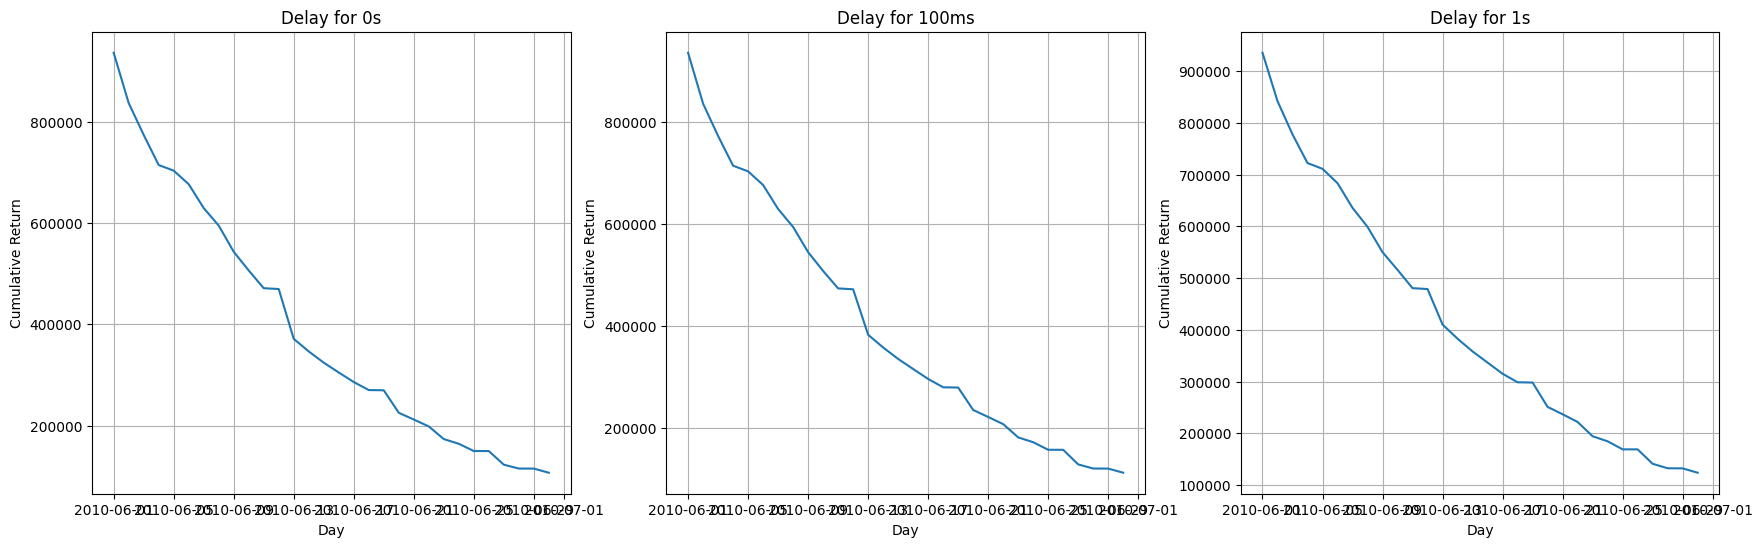

In [86]:
# test plot for MOM

delay = [0, 1, 10]
name = ['0s','100ms','1s']
fig, ax = plt.subplots(1,3, figsize=(21,6))

for i, j in enumerate(delay):
    mom = momentum_in_price_signal(df, 1200, 2600, 0.003, j)
    mom_df = execute_trading_signal(df, mom, order_size=1_000_000)
    ax[i].plot(mom_df.set_index('Time').resample('D').last().cum_return)
    ax[i].set_xlabel('Day')
    ax[i].set_ylabel('Cumulative Return')
    ax[i].set_title(f'Delay for {name[i]}')
    ax[i].grid(True)

plt.show()

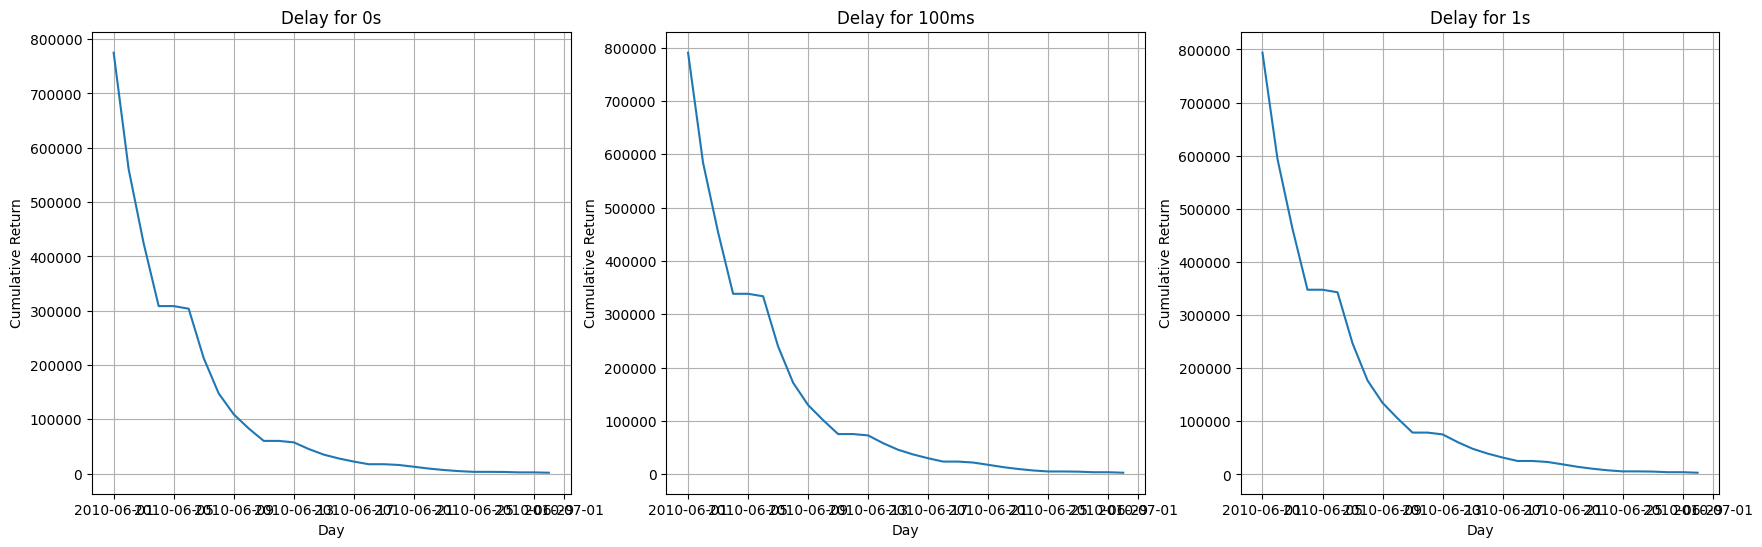

In [87]:
# test plot for OBV

delay = [0, 1, 10]
name = ['0s','100ms','1s']
fig, ax = plt.subplots(1,3, figsize=(21,6))

for i, j in enumerate(delay):
    signal1 = spread_order_imbalance(df, 100, 300, i)
    obv_df = execute_trading_signal(df, signal1, order_size=1_000_000)
    ax[i].plot(obv_df.set_index('Time').resample('D').last().cum_return)
    ax[i].set_xlabel('Day')
    ax[i].set_ylabel('Cumulative Return')
    ax[i].set_title(f'Delay for {name[i]}')
    ax[i].grid(True)

plt.show()